# Control System Design

## Linearização da planta

Para a aplicação de um controle no sistema é necessário a linearização das equações da dinâmica do satélite.

No contexto para pequenos ângulos a linearização se dá pela substituição de sin $\theta$ $\approx$ $\theta$ e cos $\theta$ $\approx$ 1,
tem-se portanto:

$\ddot{\phi}=\frac{1}{J_x}(\omega_o^2(J_z-J_y)\phi+\omega_o(J_x+J_z-J_y) \dot{\psi}+T_x)$

$\ddot{\theta}=\frac{T_y}{J_y}$

$\ddot{\psi}=\frac{1}{J_z}(-\omega_o^2(J_y-J_x)\psi-\omega_o(J_z-J_y+J_x) \dot{\phi}+T_z)$


/home/gabrielas/.cache/pypoetry/virtualenvs/labvirt-ws-LlSrLee8-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


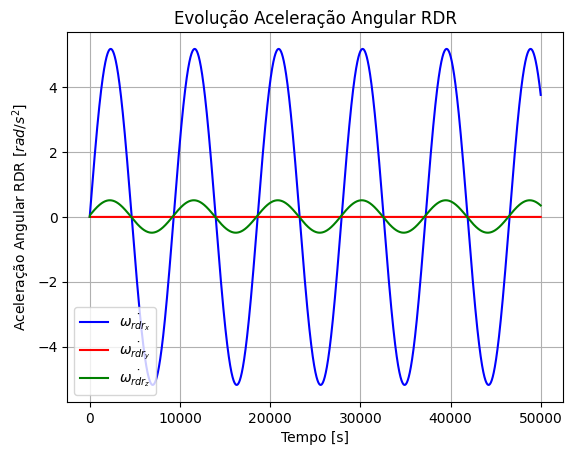

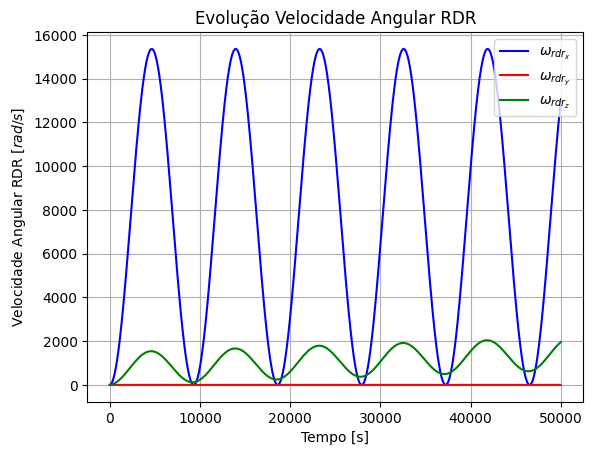

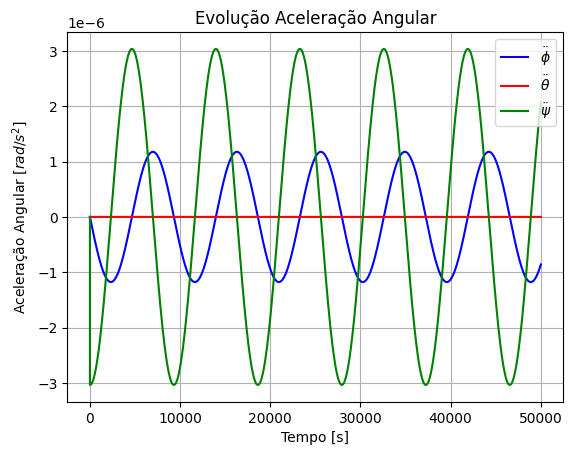

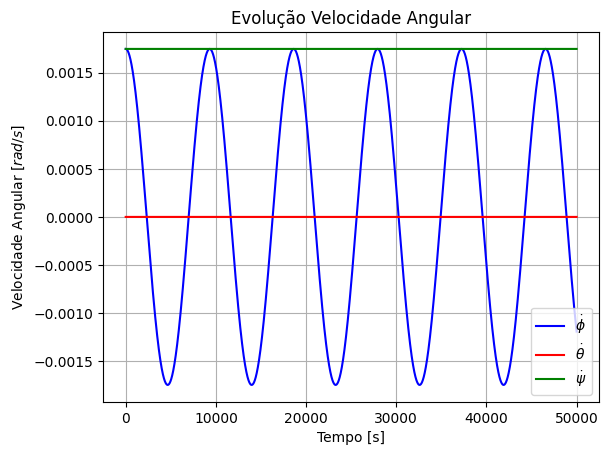

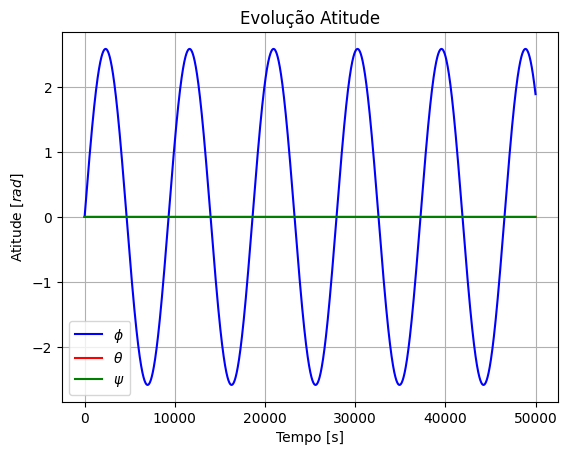

In [1]:
import matplotlib.pyplot as plt
from numpy import pi
import numpy as np

mu_Terra = 3.98600441e+014

def osv2eko(r_SCGI, v_SCGI):
    global mu_Terra
    # versores sistema de coordenadas inercial centrado na terra J2000
    vec_k = np.array([0, 0, 1])
    vec_i = np.array([1, 0, 0])
    # Elementos orbitais clássicos
    h = np.cross(r_SCGI, v_SCGI) # [m**2/s]
    p = np.dot(h, h)/mu_Terra # [m]
    B = np.cross(v_SCGI,h) - mu_Terra * r_SCGI / np.linalg.norm(r_SCGI) # [m^3/s**2]
    e = B/mu_Terra
    a = p/(1-np.dot(e, e)) # [m]
    vec_N = np.cross(vec_k, h) # [m**2/s]
    i = np.arccos(np.dot(vec_k, h)/np.linalg.norm(h))
    RAAN = np.arccos(np.dot(vec_i, vec_N)/np.linalg.norm(vec_N)) # [rad]
    omega = np.arccos(np.dot(e, vec_N)/(np.linalg.norm(e)*np.linalg.norm(vec_N))) # [rad]
    f = np.real(np.arccos(np.dot(r_SCGI, e)/(np.linalg.norm(e)*np.linalg.norm(r_SCGI)))) # [rad]
    return  [a, e, i, RAAN, omega, f]


r_SCGI = np.array([2.25526213722520e+006, -3.00492371279401e+006, -5.84397331427593e+006]) # m
v_SCGI = np.array([-5.19923341417592e+003, 3.82519438208177e+003, -3.97333292224794e+003]) # m/s
[a, e, i, RAAN, omega, f] = osv2eko(r_SCGI, v_SCGI)


movimentoMedio = np.sqrt(mu_Terra/a**3) # [rad/s]
w_O_I_O = movimentoMedio

samples = 1000000
dt = 0.05
time = np.zeros((samples, 1))
phi = np.zeros((samples, 1))
theta = np.zeros((samples, 1))
psi = np.zeros((samples, 1))
dotphi = np.zeros((samples, 1))
dottheta = np.zeros((samples, 1))
dotpsi = np.zeros((samples, 1))
ddotphi = np.zeros((samples, 1))
ddottheta = np.zeros((samples, 1))
ddotpsi = np.zeros((samples, 1))
w_rdr_x = np.zeros((samples, 1))
w_rdr_y = np.zeros((samples, 1))
w_rdr_z = np.zeros((samples, 1))
dotw_rdr_x = np.zeros((samples, 1))
dotw_rdr_y = np.zeros((samples, 1))
dotw_rdr_z = np.zeros((samples, 1))
T_x = np.zeros((samples, 1))
T_y = np.zeros((samples, 1))
T_z = np.zeros((samples, 1))

phi[0] = np.deg2rad(0)
theta[0] = np.deg2rad(0)
psi[0] = np.deg2rad(0)

dotphi[0] = np.deg2rad(0.1)
dottheta[0] = np.deg2rad(0)
dotpsi[0] = np.deg2rad(0.1)

# For a CubeSat 6U
cubeSatMass = 6 #  [kg] 
cubeSatLength = 0.1 # [m] -> x
cubeSatWidth = 0.2 # [m] -> y
cubeSatHeight = 0.3 # [m] -> z

Ixx = 1 /12 * cubeSatMass * ((cubeSatWidth ** 2) + (cubeSatHeight ** 2)) # slug * ft ^ 2
Iyy = 1 / 12 * cubeSatMass * ((cubeSatLength ** 2) + (cubeSatHeight ** 2)) # slug * ft ^ 2
Izz = 1 / 12 * cubeSatMass * ((cubeSatWidth ** 2) + (cubeSatLength ** 2)) # slug * ft ^ 2

# For a RDR
m_rdr = 0.137 # [kg]
r_rdr = 0.0435 # [m]
I_rdr = 0.5*m_rdr*r_rdr**2 # [kg*m²]

K_phi_rdr_x =       02.00359364  
K_psi_rdr_x =       00.501469208
K_dotphi_rdr_x =    20.0587683
K_dotpsi_rdr_x =    00.0335758324
K_phi_rdr_z =       00.192872772
K_psi_rdr_z =       00.772861006
K_dotphi_rdr_z =    20.9848952
K_dotpsi_rdr_z =    07.71491090


for i in range(len(time)-1):
    time[i+1] = time[i]+dt 

    # Controle

    dotw_rdr_x[i+1] = K_phi_rdr_x*phi[i]+K_psi_rdr_x*psi[i]+K_dotphi_rdr_x*dotphi[i]+K_dotpsi_rdr_x*dotpsi[i]
    dotw_rdr_z[i+1] = K_phi_rdr_z*phi[i]+K_psi_rdr_z*psi[i]+K_dotphi_rdr_z*dotphi[i]+K_dotpsi_rdr_z*dotpsi[i]  


    w_rdr_x[i+1] = w_rdr_x[i]+dotw_rdr_x[i+1]*dt     
    w_rdr_z[i+1] = w_rdr_z[i]+dotw_rdr_z[i+1]*dt  

    # Planta
    ddotphi[i+1] = 1/Ixx*(w_O_I_O**2*(Izz-Iyy)*phi[i]+w_O_I_O*(Ixx+Izz-Iyy)*psi[i]+T_x[i+1])
    ddottheta[i+1] = T_y[i]/Iyy
    ddotpsi[i+1] = 1/Izz*(-w_O_I_O**2*(Iyy-Ixx)*psi[i]-w_O_I_O*(Izz-Iyy+Ixx)*dotphi[i]+T_z[i+1])

    dotphi[i+1] = dotphi[i]+ddotphi[i+1]*dt
    dottheta[i+1] = dottheta[i]+ddottheta[i+1]*dt
    dotpsi[i+1] = dotpsi[i]+dotpsi[i+1]*dt

    phi[i+1] = phi[i]+dotphi[i+1]*dt
    theta[i+1] = theta[i]+dottheta[i+1]*dt
    psi[i+1] = psi[i]+psi[i+1]*dt 



plt.figure()
plt.title('Evolução Aceleração Angular RDR')
plt.plot(time,dotw_rdr_x,'b',label=r'$\dot{\omega_{rdr_x}}$')
plt.plot(time,dotw_rdr_y,'r',label=r'$\dot{\omega_{rdr_y}}$')
plt.plot(time,dotw_rdr_z,'g',label=r'$\dot{\omega_{rdr_z}}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Aceleração Angular RDR [$rad/s^2$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Velocidade Angular RDR')
plt.plot(time,w_rdr_x,'b',label=r'$\omega_{rdr_x}$')
plt.plot(time,w_rdr_y,'r',label=r'$\omega_{rdr_y}$')
plt.plot(time,w_rdr_z,'g',label=r'$\omega_{rdr_z}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Velocidade Angular RDR [$rad/s$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)


# Resultado Torque por Velocidade de Rotação
plt.figure()
plt.title('Evolução Aceleração Angular')
plt.plot(time,ddotphi,'b',label=r'$\ddot{\phi}$')
plt.plot(time,ddottheta,'r',label=r'$\ddot{\theta}$')
plt.plot(time,ddotpsi,'g',label=r'$\ddot{\psi}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Aceleração Angular [$rad/s^2$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Velocidade Angular')
plt.plot(time,dotphi,'b',label=r'$\dot{\phi}$')
plt.plot(time,dottheta,'r',label=r'$\dot{\theta}$')
plt.plot(time,dotpsi,'g',label=r'$\dot{\psi}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Velocidade Angular [$rad/s$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Atitude')
plt.plot(time,phi,'b',label=r'$\phi$')
plt.plot(time,dottheta,'r',label=r'$\theta$')
plt.plot(time,psi,'g',label=r'$\psi$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Atitude [$rad$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.grid(True)
plt.legend()


plt.show()

### Em espaço de estados teria-se:

- Meu vetor de estados é:

$X = [\phi, \: \theta, \: \psi, \: \dot{\phi}, \: \dot{\theta}, \: \dot{\psi}]^T$

- Por sua vez a derivada do meu vetor de estados fica:

$\dot{X} = [\dot{\phi}, \: \dot{\theta}, \: \dot{\psi}, \: \ddot{\phi}, \: \ddot{\theta}, \: \ddot{\psi}]^T$

- Meu vetor de controle:

$U = [\dot{\omega_{rdr_x}}, \:,\dot{\omega_{rdr_y}} \:, \dot{\omega_{rdr_z}}]^T$

Sendo a equação fundamental:

$
A = \begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\frac{1}{J_x}*(\omega_o^2(J_z-J_y)) & 0 & 0 & 0 & 0 & \frac{1}{J_x}*(\omega_o(J_x+J_z-J_y)) \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \frac{1}{J_z}*(-\omega_o^2(J_y-J_x)) & \frac{1}{J_z}*(-\omega_o(J_z-J_y+J_x)) & 0 & 0
\end{bmatrix}
$

$
B = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\frac{1}{J_{rdr}} & 0 & 0 \\
0 & \frac{1}{J_{rdr}} & 0 \\
0 & 0 & \frac{1}{J_{rdr}} \\
\end{bmatrix}
$

$\dot{X} = A\:X+B\:U$

Perceba que olhando para a matriz A tem-se que o comportamento de $\theta$, $\dot{\theta}$ e $\omega_{{rdr}_y}$ é separado do resto do sistema
assim pode-se separar o estudo em um MIMO e um SISO:
- MIMO -> comportamento de $\phi$ $\psi$, $\dot{\phi}$ $\dot{\psi}$ e $\omega_{{rdr}_x}$ $\omega_{{rdr}_z}$ que são acoplados
- SISO -> comportamento de $\theta$, $\dot{\theta}$ e $\omega_{{rdr}_y}$

### MIMO:


- Meu vetor de estados é:

$X = [\phi, \: \psi, \: \dot{\phi}, \: \dot{\psi}]^T$

- Por sua vez a derivada do meu vetor de estados fica:

$\dot{X} = [\dot{\phi}, \: \dot{\psi}, \: \ddot{\phi}, \: \ddot{\psi}]^T$

- Meu vetor de controle:

$U = [\dot{\omega_{rdr_x}}, \:, \:, \dot{\omega_{rdr_z}}]^T$

Sendo a equação fundamental:

$
A = \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\frac{1}{J_x}*(\omega_o^2(J_z-J_y)) & 0 & 0 & \frac{1}{J_x}*(\omega_o(J_x+J_z-J_y)) \\
0 & \frac{1}{J_z}*(-\omega_o^2(J_y-J_x)) & \frac{1}{J_z}*(-\omega_o(J_z-J_y+J_x))& 0
\end{bmatrix}
$

$
B = \begin{bmatrix}
0 & 0 \\
0 & 0 \\
\frac{J_{rdr}}{J_{xx}} & 0 \\
0 & \frac{J_{rdr}}{J_{zz}} \\
\end{bmatrix}
$

$\dot{X} = A\:X+B\:U$

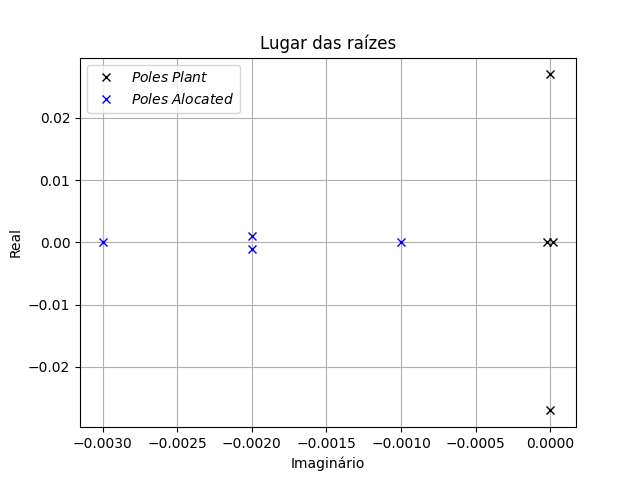

Plant Poles
[ 3.25260652e-19+0.02698568j  3.25260652e-19-0.02698568j
 -2.10730501e-05+0.j          2.10730501e-05+0.j        ]

Alocated Poles
[-0.003+0.j    -0.001+0.j    -0.002-0.001j -0.002+0.001j]

Gain Matrix
[[ 1.77755750e-03  5.01469208e-04  2.00587683e+00  3.35758324e-01]
 [ 1.92872772e-04  9.08482690e-04 -2.09848952e+02  7.71491090e-01]]



In [7]:
# Control Design of MIMO phi psi dotphi dotpsi dotomega_rdr_x and dotomega_rdr_z
import control
from scipy import signal
%matplotlib widget

states = ['phi', 'psi', 'dotphi', 'dotpsi']
inputs = ['dotomega_rdr_x', 'dotomega_rdr_z']

A_Plant = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1/Ixx*w_O_I_O**2*(Izz-Iyy), 0, 0, 1/Ixx*w_O_I_O*(Ixx+Izz-Iyy)],
    [0, 1/Izz*-w_O_I_O**2*(Iyy-Ixx), 1/Izz*-w_O_I_O/(Izz-Iyy+Ixx),0]
])

B_Plant = np.array([
    [0, 0],
    [0, 0],
    [I_rdr/Ixx, 0],
    [0, I_rdr/Izz],
])
num_inputs  = B_Plant.shape[1]
num_outputs = A_Plant.shape[0]
C_Plant = np.eye(num_outputs)
D__Plant = np.zeros([num_outputs,num_inputs])

sys_Plant = control.StateSpace(A_Plant,B_Plant,C_Plant,D__Plant)

plt.figure()
plt.title("Lugar das raízes")
poles_Plant = sys_Plant.poles()
plt.plot(poles_Plant.real, poles_Plant.imag, 'kx', label=r'$Poles \; Plant$')

plt.xlabel("Imaginário")
plt.ylabel("Real")
plt.grid(True)

P = np.array([-3, -1, -2-1j, -2+1j]) / 1000
fsf = signal.place_poles(A_Plant, B_Plant, P, method='YT')
plt.plot(fsf.computed_poles.real, fsf.computed_poles.imag, 'bx', label=r'$Poles \; Alocated$')
plt.legend()
plt.show()

print("Plant Poles")
print(poles_Plant)
print("")
print("Alocated Poles")
print(fsf.computed_poles)
print("")
print("Gain Matrix")
print(fsf.gain_matrix)
print("")


### SISO:


- Meu vetor de estados é:

$X = [\theta, \: \dot{\theta}]^T$

- Por sua vez a derivada do meu vetor de estados fica:

$\dot{X} = [\dot{\theta}, \: \ddot{\theta}]^T$

- Meu vetor de controle:

$U = \dot{\omega_{rdr_y}}$

Sendo a equação fundamental:

$
A = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix}
$

$
B = \begin{bmatrix}
0 & 0 \\
0 & \frac{J_{rdr}}{J_{yy}} \\
\end{bmatrix}
$

$\dot{X} = A\:X+B\:U$

ControlMIMONotImplemented: sys must be single-input single-output (SISO)

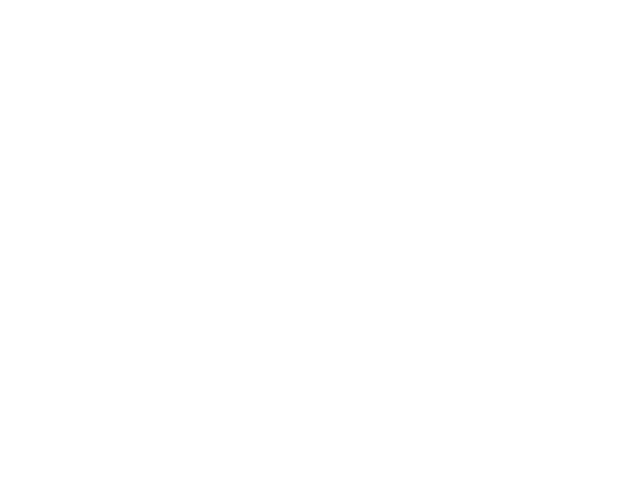

In [11]:
# Control Design of SISO theta dottheta dotomega_rdr_y
import control
from scipy import signal
%matplotlib widget

states = ['theta', 'dottheta']
inputs = ['dotomega_rdr_y']

A_Plant = np.array([
    [1, 0],
    [0, 1],
])

B_Plant = np.array([
    [0, 0],
    [0, I_rdr/Iyy],
])

num_inputs  = B_Plant.shape[1]
num_outputs = A_Plant.shape[0]
C_Plant= np.eye(num_outputs)
D_Plant = np.zeros([num_outputs,num_inputs])

sys_Plant= control.StateSpace(A_Plant,B_Plant,C_Plant,D_Plant)

plt.figure()
control.root_locus(sys_Plant)
plt.title(r"\dot{\theta} vs \dot{\omega_{{rdr}_y}} - Open Loop")
plt.xlabel("Real")
plt.ylabel("Imaginary")

exit()
